## Trabalho 2 - Análise de scripts da trilogia "Star wars"
#### INF1030 - Introdução a ciência dos dados

#### Alunos: Leonardo E. Wajnsztok e Samuel Bastos

In [100]:
import pandas as pd
import matplotlib
import warnings
warnings.filterwarnings('ignore')


In [101]:
SW_EP4 = 'Star Wars: Episode IV - A New Hope'
SW_EP5 = 'Star Wars: Episode V - The Empire Strikes Back'
SW_EP6 = 'Star Wars: Episode VI - Return of the Jedi'

movies = [
    {'script': 'star-wars-movie-scripts/SW_EpisodeIV.txt', 'movie': SW_EP4},
    {'script': 'star-wars-movie-scripts/SW_EpisodeV.txt', 'movie': SW_EP5},
    {'script': 'star-wars-movie-scripts/SW_EpisodeVI.txt', 'movie': SW_EP6},
]

In [102]:
trilogy = pd.DataFrame()

for m in movies:
    episode = pd.read_table(m['script'], delim_whitespace=True, header=0, escapechar='\\')
    episode['movie'] = m['movie']    
    trilogy = trilogy.append(episode)

In [103]:
trilogy.shape

(2523, 3)

## Cleaning

In [104]:
import string
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

stop_words_set = set(stopwords.words("english"))
stop_words_set.add("'s")
stop_words_set.add("re")
stop_words_set.add("ll")
stop_words_set.add("ve")
stemmer = SnowballStemmer('english')

def clean(x):
    x = x.lower()
    tokens = nltk.word_tokenize(x)
    tokens = [t for t in tokens if t not in set(string.punctuation)]
    tokens = [t for t in tokens if t not in stop_words_set]
    tokens = [stemmer.stem(t) for t in tokens]
    tokens = [t for t in tokens if t not in stop_words_set]
    return ' '.join(tokens)
    
trilogy['dialogue_clean'] = trilogy['dialogue'].apply(clean)
trilogy['n_words'] = trilogy['dialogue_clean'].apply(lambda x: len(nltk.word_tokenize(x)))
trilogy = trilogy[trilogy.n_words > 5]



In [105]:
trilogy.shape

(869, 5)

In [106]:
trilogy.head()

,character,dialogue,movie,dialogue_clean,n_words
1,THREEPIO,Did you hear that? They've shut down the main...,Star Wars: Episode IV - A New Hope,hear shut main reactor destroy sure mad,7
5,THREEPIO,I should have known better than to trust the l...,Star Wars: Episode IV - A New Hope,known better trust logic half-siz thermocapsul...,9
9,THREEPIO,They're heading in this direction. What are we...,Star Wars: Episode IV - A New Hope,head direct go sent spice mine kessel smash know,9
13,REBEL OFFICER,We intercepted no transmissions. Aaah... This...,Star Wars: Episode IV - A New Hope,intercept transmiss aaah ... consular ship dip...,8
15,VADER,"Commander, tear this ship apart until you've f...",Star Wars: Episode IV - A New Hope,command tear ship apart found plan bring ambas...,10


## Models and hyper parameters

In [10]:
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier

seed = 42

# models_params = [
#     ('LinearSVC', LinearSVC(random_state=seed), {'m__C': [0.1, 1, 10], 'm__dual': [True, False]}),
#     ('KNN', KNeighborsClassifier(), {'m__n_neighbors': range(3,30)}),
#     ('Decision Tree', DecisionTreeClassifier(random_state=seed), {'m__max_depth': range(3, 20)}),
#     ('Gradient Boosting', GradientBoostingClassifier(random_state=seed), {'m__n_estimators': [100, 200, 300]}),
#     ('Random Forest', RandomForestClassifier(random_state=seed), { "m__n_estimators": [10, 30, 50, 70]}),
#     ('Logistic Regression', LogisticRegression(), {}),
#     ('SGD', SGDClassifier(random_state=seed), { 'm__alpha': (1e-2, 1e-3),
#                                                 'm__max_iter': (1000, 2000),
#                                                 'm__penalty': ('l2',),
#                                                }),
#     ('Gaussian Naive Bayes', GaussianNB(), {}),
#     ('Multinomial Naive Bayes', MultinomialNB(), {}),
#     ('Multilayer Perceptron', MLPClassifier(random_state=seed), {'m__max_iter': [500, 1000]})
# ]
models_params = [
    ('LinearSVC', LinearSVC(random_state=seed), {}),
    ('KNN', KNeighborsClassifier(), {}),
    ('Decision Tree', DecisionTreeClassifier(random_state=seed), {}),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=seed),{}),
    ('Random Forest', RandomForestClassifier(random_state=seed), {}),
    ('Logistic Regression', LogisticRegression(), {}),
    ('SGD', SGDClassifier(random_state=seed), {}),
    ('Multilayer Perceptron', MLPClassifier(random_state=seed), {})
]

## Data Pipeline

In [88]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import strip_accents_ascii
from sklearn import cross_validation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from pandas_ml.confusion_matrix import LabeledConfusionMatrix
import matplotlib.pyplot as plt

test_size = 0.3
seed = 42

def apply_validation_pipeline(name, model, params, X_train, y_train):
    parameters = {
      'vect__ngram_range': [(1, 1), (1, 2),],
      'vect__max_features': (200, 300),
      'vect__max_df': (0.5, 0.75, 1.0),
      'tfidf__use_idf': (True, False),
      'tfidf__norm': ('l1', 'l2'),
    }
    parameters.update(params)
    pipe = Pipeline([('vect', CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
                   ('m', model)])
  
    grid = GridSearchCV(pipe, parameters, n_jobs=1)
    grid = grid.fit(X_train, y_train)

    print ("Model: "+ name)
    print ("Best cross-validation score: " + str(grid.best_score_))
    print ("Best parameters: " + str(grid.best_params_))
    return grid, grid.best_score_

def test_models(name, X_test, y_test, trained_model):
    predictions = trained_model.predict(X_test)
    print ("Model: "+ name)
    test_accuracy = accuracy_score(y_test, predictions)
    print ("Accuracy score :" + str(test_accuracy))
    cm = LabeledConfusionMatrix(y_test.tolist(), predictions.tolist())
    print (cm)
    print (classification_report(y_test, predictions))
    return test_accuracy

## Predicting to which movie a quote belongs

In [217]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(trilogy.dialogue_clean, trilogy.movie, test_size=test_size, random_state=seed)

In [218]:
models_info = []

for name, model, params in models_params:
    trained_model, val_accuracy = apply_validation_pipeline(name, model, params, X_train_raw, y_train)
    models_info.append({
        'name': name,
        'X_test': X_test_raw, 'y_test': y_test,
        'trained_model': trained_model, 'validation_accuracy': val_accuracy
    })

In [221]:
for mi in  models_info:
    mi['test_accuracy'] = test_models(mi['name'], mi['X_test'], mi['y_test'], mi['trained_model'])

Model: LinearSVC
Accuracy score :0.5574712643678161
[[58 14  7]
 [20 15 15]
 [13  8 24]]
                                                precision    recall  f1-score   support

            Star Wars: Episode IV - A New Hope       0.64      0.73      0.68        79
Star Wars: Episode V - The Empire Strikes Back       0.41      0.30      0.34        50
    Star Wars: Episode VI - Return of the Jedi       0.52      0.53      0.53        45

                                   avg / total       0.54      0.56      0.55       174

Model: KNN
Accuracy score :0.5287356321839081
[[70  8  1]
 [35 10  5]
 [22 11 12]]
                                                precision    recall  f1-score   support

            Star Wars: Episode IV - A New Hope       0.55      0.89      0.68        79
Star Wars: Episode V - The Empire Strikes Back       0.34      0.20      0.25        50
    Star Wars: Episode VI - Return of the Jedi       0.67      0.27      0.38        45

                               

In [222]:
models_info[0]['trained_model'].predict(['these are not the droids you are looking for'])

array(['Star Wars: Episode IV - A New Hope'], dtype=object)

In [223]:
models_info[0]['trained_model'].predict([' Oh. They ve encased him in Carbonite. He should be quite well protected. If he survived the freezing process, that is.'])

array(['Star Wars: Episode V - The Empire Strikes Back'], dtype=object)

## Predicting to which character a quote belongs

In [48]:
trilogy.character.unique()

array(['THREEPIO', 'VADER', 'BIGGS', 'LUKE', 'LEIA', 'BEN', 'TARKIN',
       'HAN', 'YODA', 'LANDO'], dtype=object)

In [91]:
main_characters = [
    'THREEPIO', 'VADER', 'LUKE','EMPEROR',
    'LEIA', 'BEN', 'HAN', 'YODA', 'LANDO', 
]

In [107]:
trilogy = trilogy[trilogy.character.isin(main_characters)]
trilogy.shape

(681, 5)

In [108]:
trilogy.groupby(trilogy.character).count()

,dialogue,movie,dialogue_clean,n_words
character,,,,
BEN,54,54,54,54
EMPEROR,23,23,23,23
HAN,154,154,154,154
LANDO,37,37,37,37
LEIA,47,47,47,47
LUKE,141,141,141,141
THREEPIO,149,149,149,149
VADER,53,53,53,53
YODA,23,23,23,23


In [109]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(trilogy.dialogue_clean, trilogy.character, test_size=0.3, random_state=seed)

In [110]:
models_info = []

for name, model, params in models_params:
    trained_model, val_accuracy = apply_validation_pipeline(name, model, params, X_train_raw, y_train)
    models_info.append({
        'name': name,
        'X_test': X_test_raw, 'y_test': y_test,
        'trained_model': trained_model, 'validation_accuracy': val_accuracy
    })

Model: LinearSVC
Best cross-validation score: 0.4579831932773109
Best parameters: {'tfidf__norm': 'l2', 'tfidf__use_idf': False, 'vect__max_df': 0.5, 'vect__max_features': 300, 'vect__ngram_range': (1, 1)}
Model: KNN
Best cross-validation score: 0.3907563025210084
Best parameters: {'tfidf__norm': 'l2', 'tfidf__use_idf': False, 'vect__max_df': 0.5, 'vect__max_features': 300, 'vect__ngram_range': (1, 2)}
Model: Decision Tree
Best cross-validation score: 0.3802521008403361
Best parameters: {'tfidf__norm': 'l2', 'tfidf__use_idf': False, 'vect__max_df': 0.5, 'vect__max_features': 300, 'vect__ngram_range': (1, 2)}
Model: Gradient Boosting
Best cross-validation score: 0.3760504201680672
Best parameters: {'tfidf__norm': 'l2', 'tfidf__use_idf': True, 'vect__max_df': 0.5, 'vect__max_features': 300, 'vect__ngram_range': (1, 2)}
Model: Random Forest
Best cross-validation score: 0.39915966386554624
Best parameters: {'tfidf__norm': 'l2', 'tfidf__use_idf': False, 'vect__max_df': 0.5, 'vect__max_featu

In [111]:
for mi in  models_info:
    mi['test_accuracy'] = test_models(mi['name'], mi['X_test'], mi['y_test'], mi['trained_model'])

Model: LinearSVC
Accuracy score :0.5073170731707317
Predicted  BEN  EMPEROR  HAN  LANDO  LEIA  LUKE  THREEPIO  VADER  YODA  \
Actual                                                                   
BEN          1        0    4      0     0     1         1      1     0   
EMPEROR      1        2    0      0     0     0         1      2     2   
HAN          1        0   27      0     1    12         4      1     0   
LANDO        0        0    3      1     0     2         0      1     0   
LEIA         2        0    4      0     4     7         0      1     0   
LUKE         2        1   11      0     1    20         7      1     0   
THREEPIO     1        1    6      2     2     3        40      1     1   
VADER        1        1    1      0     1     1         0      7     0   
YODA         2        0    0      0     1     1         0      0     2   
__all__     11        5   56      3    10    47        53     15     5   

Predicted  __all__  
Actual              
BEN              

In [121]:
models_info[0]['trained_model'].predict(['I’m talking about the big Corellian ships now. She’s fast enough for you, old man.'])

array(['HAN'], dtype=object)

In [113]:
models_info[0]['trained_model'].predict(['you are a rebel and a traitor'])

array(['VADER'], dtype=object)

## Predicting which characters are good or evil

In [125]:
main_characters = [
    'THREEPIO', 'VADER', 'LUKE', 'TARKIN',
    'LEIA', 'BEN', 'HAN', 'YODA', 'LANDO',
    'EMPEROR'
]

good_characters = [
    'THREEPIO', 'LUKE',
    'LEIA', 'BEN', 'HAN', 'YODA',
]

evil_characters = ['VADER', 'EMPEROR', 'TARKIN']


def good_or_evil(x):
    if x in good_characters:
        return 'good'
    else:
        return 'evil'
    
trilogy = trilogy[trilogy.character.isin(main_characters)]
trilogy['good_evil'] = trilogy.character.apply(good_or_evil)
trilogy.shape

(681, 6)

In [126]:
trilogy.head()

,character,dialogue,movie,dialogue_clean,n_words,good_evil
1,THREEPIO,Did you hear that? They've shut down the main...,Star Wars: Episode IV - A New Hope,hear shut main reactor destroy sure mad,7,good
5,THREEPIO,I should have known better than to trust the l...,Star Wars: Episode IV - A New Hope,known better trust logic half-siz thermocapsul...,9,good
9,THREEPIO,They're heading in this direction. What are we...,Star Wars: Episode IV - A New Hope,head direct go sent spice mine kessel smash know,9,good
15,VADER,"Commander, tear this ship apart until you've f...",Star Wars: Episode IV - A New Hope,command tear ship apart found plan bring ambas...,10,evil
19,THREEPIO,"Don't call me a mindless philosopher, you over...",Star Wars: Episode IV - A New Hope,n't call mindless philosoph overweight glob gr...,10,good


In [127]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(trilogy.dialogue_clean, trilogy.good_evil, test_size=0.3, random_state=seed)

In [128]:
models_info = []

for name, model, params in models_params:
    trained_model, val_accuracy = apply_validation_pipeline(name, model, params, X_train_raw, y_train)
    models_info.append({
        'name': name,
        'X_test': X_test_raw, 'y_test': y_test,
        'trained_model': trained_model, 'validation_accuracy': val_accuracy
    })

Model: LinearSVC
Best cross-validation score: 0.8361344537815126
Best parameters: {'tfidf__norm': 'l1', 'tfidf__use_idf': False, 'vect__max_df': 0.5, 'vect__max_features': 200, 'vect__ngram_range': (1, 2)}
Model: KNN
Best cross-validation score: 0.8382352941176471
Best parameters: {'tfidf__norm': 'l2', 'tfidf__use_idf': False, 'vect__max_df': 0.5, 'vect__max_features': 300, 'vect__ngram_range': (1, 1)}
Model: Decision Tree
Best cross-validation score: 0.7941176470588235
Best parameters: {'tfidf__norm': 'l1', 'tfidf__use_idf': False, 'vect__max_df': 0.5, 'vect__max_features': 300, 'vect__ngram_range': (1, 1)}
Model: Gradient Boosting
Best cross-validation score: 0.8130252100840336
Best parameters: {'tfidf__norm': 'l2', 'tfidf__use_idf': False, 'vect__max_df': 0.5, 'vect__max_features': 300, 'vect__ngram_range': (1, 1)}
Model: Random Forest
Best cross-validation score: 0.8235294117647058
Best parameters: {'tfidf__norm': 'l1', 'tfidf__use_idf': True, 'vect__max_df': 0.5, 'vect__max_featur

In [129]:
for mi in  models_info:
    mi['test_accuracy'] = test_models(mi['name'], mi['X_test'], mi['y_test'], mi['trained_model'])

Model: LinearSVC
Accuracy score :0.8780487804878049
Predicted  evil  good  __all__
Actual                        
evil          7    20       27
good          5   173      178
__all__      12   193      205
             precision    recall  f1-score   support

       evil       0.58      0.26      0.36        27
       good       0.90      0.97      0.93       178

avg / total       0.86      0.88      0.86       205

Model: KNN
Accuracy score :0.8731707317073171
Predicted  evil  good  __all__
Actual                        
evil          4    23       27
good          3   175      178
__all__       7   198      205
             precision    recall  f1-score   support

       evil       0.57      0.15      0.24        27
       good       0.88      0.98      0.93       178

avg / total       0.84      0.87      0.84       205

Model: Decision Tree
Accuracy score :0.8292682926829268
Predicted  evil  good  __all__
Actual                        
evil          9    18       27
good         

## Word2Vec Embedding

In [138]:
from gensim.models import Word2Vec

trilogy['tokens'] = trilogy.dialogue_clean.apply(lambda x: x.split())

# train model
model = Word2Vec(trilogy.tokens, min_count=1)

# summarize the loaded model
print(model)

# summarize vocabulary
words = list(model.wv.vocab)
# print(words)

# access vector for one word
# print(model['master'])

# save model
model.save('model.bin')

model.most_similar('darth')

Word2Vec(vocab=1564, size=100, alpha=0.025)


[('luke', 0.45306143164634705),
 ('ben', 0.40591147541999817),
 ('wait', 0.4028037190437317),
 ('noth', 0.39825114607810974),
 ('littl', 0.3719812333583832),
 ('creat', 0.3714582920074463),
 ('side', 0.37134501338005066),
 ('strong', 0.36625486612319946),
 ('threat', 0.3578658699989319),
 ('hope', 0.3520909547805786)]

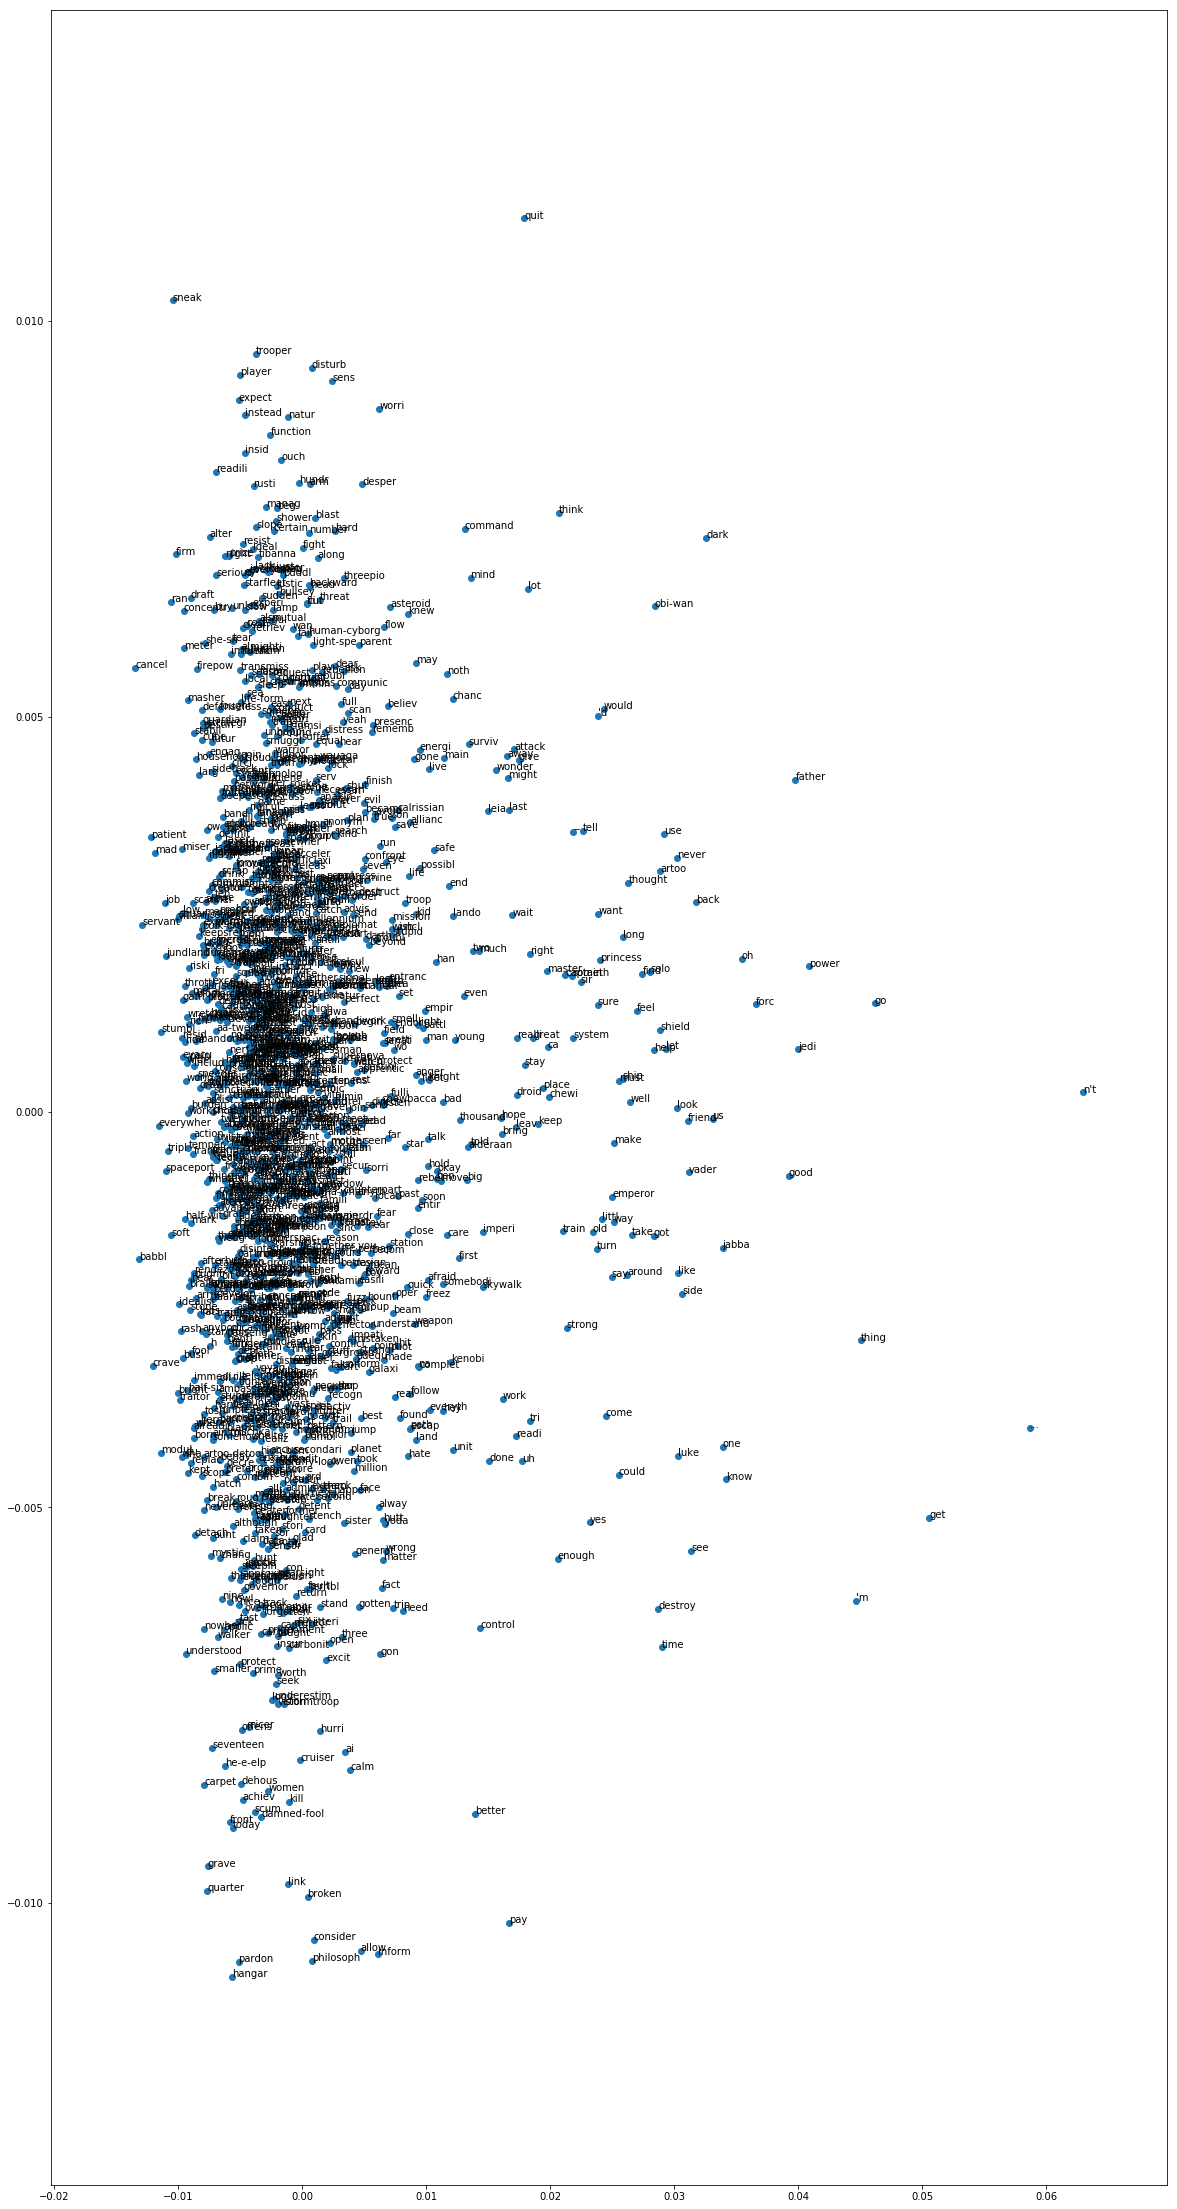

In [148]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
plt.figure(figsize=(20, 40))
plt.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

## Named Entity Recognition

In [166]:
from nltk.chunk import tree2conlltags
from nltk import pos_tag, ne_chunk, word_tokenize


trilogy['chunk'] = trilogy.dialogue.apply(lambda sentence:ne_chunk(pos_tag(word_tokenize(sentence))))
trilogy['chunk_tagged'] = trilogy.chunk.apply(lambda chunk:tree2conlltags(chunk))
trilogy['NE'] = trilogy['chunk_tagged'].apply(lambda chunk_list: [chunk for chunk in chunk_list if chunk[2] != 'O'])


In [179]:
ner_df = trilogy[trilogy.NE.str.len() != 0]

### Person Entities

In [198]:
trilogy['person'] = trilogy.NE.apply(lambda x: [s for s in x if s[2] == 'B-PERSON' or s[2] == 'I-PERSON'])
trilogy[trilogy.person.str.len() != 0].person

9                              [(Kessel, NNP, B-PERSON)]
42                               [(Lord, NNP, B-PERSON)]
43                              [(Rebel, NNP, B-PERSON)]
66     [(Deak, NNP, B-PERSON), (Uncle, NNP, B-PERSON)...
70                              [(Biggs, NNP, B-PERSON)]
106                               [(Sir, NNP, B-PERSON)]
112    [(Toshi, NNP, B-PERSON), (Station, NNP, I-PERS...
114                               [(Red, NNP, B-PERSON)]
129                             [(Biggs, NNP, B-PERSON)]
157                             [(Artoo, NNP, B-PERSON)]
158    [(Kenobi, NNP, B-PERSON), (Quite, NNP, B-PERSO...
159    [(Kenobi, NNP, B-PERSON), (Ben, NNP, B-PERSON)...
178         [(Ben, NNP, B-PERSON), (Ben, NNP, B-PERSON)]
191      [(Biggs, NNP, B-PERSON), (Tank, NNP, B-PERSON)]
206                               [(Boy, NNP, B-PERSON)]
216    [(Old, NNP, B-PERSON), (Ben, NNP, B-PERSON), (...
222      [(Master, NN, B-PERSON), (Luke, NNP, I-PERSON)]
223      [(Uncle, NNP, B-PERSON

### Organization Entities

In [191]:
trilogy['org'] = trilogy.NE.apply(lambda x: [s for s in x if s[2] == 'B-ORGANIZATION'])
trilogy[trilogy.org.str.len() != 0].org

15                   [(Ambassador, NNP, B-ORGANIZATION)]
32                      [(Academy, NNP, B-ORGANIZATION)]
42     [(Imperial, NNP, B-ORGANIZATION), (Senate, NNP...
44                     [(Imperial, NNP, B-ORGANIZATION)]
45                        [(Rebel, NNP, B-ORGANIZATION)]
47                        [(Rebel, NNP, B-ORGANIZATION)]
51                    [(Commander, NNP, B-ORGANIZATION)]
66                    [(Skyhopper, NNP, B-ORGANIZATION)]
86                       [(Empire, NNP, B-ORGANIZATION)]
92     [(Academy, NNP, B-ORGANIZATION), (Imperial, NN...
141                   [(Rebellion, NNP, B-ORGANIZATION)]
184                     [(Academy, NNP, B-ORGANIZATION)]
228                     [(People, NNPS, B-ORGANIZATION)]
235                    [(Jundland, NNP, B-ORGANIZATION)]
261                        [(Jedi, NNP, B-ORGANIZATION)]
262    [(Jedi, NNP, B-ORGANIZATION), (Old, NNP, B-ORG...
264    [(Empire, NNP, B-ORGANIZATION), (Jedi, NNP, B-...
266                       [(For

### Location Entities

In [192]:
trilogy['location'] = trilogy.NE.apply(lambda x: [s for s in x if s[2] == 'B-LOCATION'])
trilogy[trilogy.location.str.len() != 0].location

752    [(East, NNP, B-LOCATION)]
Name: location, dtype: object

### Facility Entities

In [193]:
trilogy['facility'] = trilogy.NE.apply(lambda x: [s for s in x if s[2] == 'B-FACILITY'])
trilogy[trilogy.facility.str.len() != 0].facility

342    [(Millennium, NNP, B-FACILITY)]
344    [(Millennium, NNP, B-FACILITY)]
498    [(Millennium, NNP, B-FACILITY)]
773    [(Millennium, NNP, B-FACILITY)]
Name: facility, dtype: object

### GPE Entities

In [194]:
trilogy['gpe'] = trilogy.NE.apply(lambda x: [s for s in x if s[2] == 'B-GPE'])
trilogy[trilogy.gpe.str.len() != 0].gpe

20                                [(Secret, JJ, B-GPE)]
42                                [(Vader, NNP, B-GPE)]
44                             [(Alderaan, NNP, B-GPE)]
82       [(Sand, NNP, B-GPE), (Anchorhead, NNP, B-GPE)]
104                                 [(Sir, NNP, B-GPE)]
108                               [(Bocce, NNP, B-GPE)]
119                                  [(R2, NNP, B-GPE)]
125                                  [(Uh, NNP, B-GPE)]
175                                  [(R2, NNP, B-GPE)]
204                                [(Sand, NNP, B-GPE)]
219                           [(Deactivate, NN, B-GPE)]
220                                [(Wait, NNP, B-GPE)]
228                                 [(Sand, NN, B-GPE)]
230                               [(Hello, NNP, B-GPE)]
233                                [(Rest, NNP, B-GPE)]
244                                 [(Sand, NN, B-GPE)]
247                                [(Sand, NNP, B-GPE)]
270    [(Alderaan, NNP, B-GPE), (Alderaan, NNP, 

## Clusters

In [247]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

number_of_clusters = 5
pipe = Pipeline([('tfidf', TfidfVectorizer()),
               ('m', KMeans(n_clusters=number_of_clusters, random_state=seed))])


pipe = pipe.fit(X_train_raw)
vec = pipe.steps[0][1]
km = pipe.steps[1][1]
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vec.get_feature_names()
for i in range(number_of_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :10]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Cluster 0: yes forc side dark father power strong must way vader
Cluster 1: see come artoo could ca oh know chewi friend ship
Cluster 2: go let artoo got one power us away think right
Cluster 3: like look much got make back may scoundrel right sound
Cluster 4: get well take us let want oh help one control


In [248]:
df = pd.DataFrame(X_train_raw)
df['cluster'] =  km.labels_


In [249]:
df.head(10)

,dialogue_clean,cluster
631,yes yes obi-wan listen cave rememb failur cave,0
599,hello welcom 'm lando calrissian 'm administr ...,1
229,two bantha n't see ... wait second sand peopl ...,1
624,ca n't keep vision head friend got help,1
302,'d crazi follow us would n't,1
637,stop must depend fulli train jedi knight forc ...,0
223,well come get late hope get back uncl owen rea...,4
70,well thing n't sinc left bigg ... quiet,4
53,get mess realli n't know seem made suffer lot ...,4
643,luke n't give hate -- lead dark side,0
